# 加载数据 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import font_manager

In [3]:
font_manager.fontManager.addfont("/home/yltang/data/Times_New_Roman.ttf")

In [4]:
plt.style.use('classic')
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size':20,
         }

In [5]:
labeled_data_file = np.load("/home/yltang/data/work_1/data/train_label_data.npz")
labeled_data = labeled_data_file["data"]
labeled_label_file = np.load("/home/yltang/data/work_1/data/train_label_label.npz")
labeled_label = labeled_label_file["data"]
unlabeled_data_file = np.load("/home/yltang/data/work_1/data/train_unlabel_data.npz")
unlabeled_data = unlabeled_data_file["data"]

In [6]:
data = np.concatenate([labeled_data, unlabeled_data], axis=0)

In [8]:
data_clone = labeled_data
label_clone = labeled_label

In [9]:
data.shape[0]/labeled_data.shape[0]

3.5026851644663237

In [10]:
for i in range(4):
    labeled_data = np.concatenate([labeled_data, data_clone], axis=0)
    labeled_label = np.concatenate([labeled_label, label_clone], axis=0)
labeled_data = labeled_data[:data.shape[0]]
labeled_label = labeled_label[:data.shape[0]]

In [11]:
labeled_data.shape, labeled_label.shape, data.shape

((31307, 90, 6), (31307, 9), (31307, 90, 6))

In [12]:
sample=0
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']
labels = ['u','g','r','i','z','y']

In [13]:
#归一化数据
def data_normal(data):
    max_flux = np.max(data[:, :, :3])
    for i in range(data.shape[0]): 
        max_flux_ = np.max(data[i, :, :3])
        for j in range(3):
            data[i, :, j] = (data[i, :, j]/max_flux_)*(np.log(max_flux_)/np.log(max_flux))
            data[i, :, j+3] = (data[i, :, j+3]/max_flux_)*(np.log(max_flux_)/np.log(max_flux))
    return data
labeled_data = data_normal(data=labeled_data)
data = data_normal(data=data)

In [14]:
# data mask
mask_time = 6
def data_mask(data):
    data[:, mask_time:, :]=0
    return data
mask_data = data_mask(data=data.copy())
mask_labeled_data = data_mask(data=labeled_data.copy())

In [15]:
mask_data.shape, mask_labeled_data.shape

((31307, 90, 6), (31307, 90, 6))

In [16]:
np.max(data)

1.0

In [17]:
mask_data.shape, data.shape, mask_labeled_data.shape, labeled_data.shape, labeled_label.shape

((31307, 90, 6), (31307, 90, 6), (31307, 90, 6), (31307, 90, 6), (31307, 9))

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


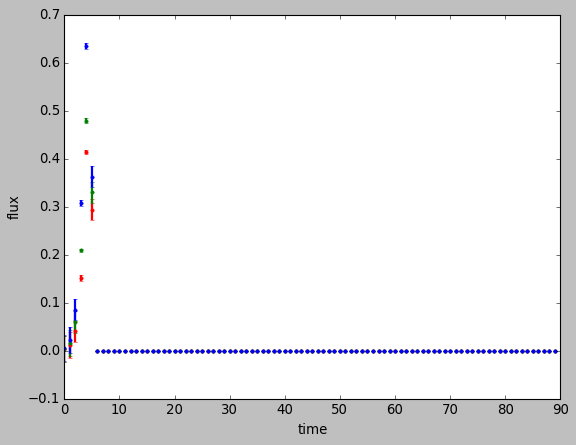

In [18]:
sample += 1
for i in range(3):
    mjd_ = np.linspace(0,89, 90)
    flux_ = mask_data[sample, :, i]
    flux_err_ = mask_data[sample, :, i+3]
    #print(flux_err_)
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt[i], elinewidth=2, capsize=2)
    plt.xlabel("time")
    plt.ylabel("flux")

print(labeled_label[sample])

# 构建模型 

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

2025-02-17 16:48:11.035093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 16:48:11.047980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 16:48:11.063089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 16:48:11.067635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 16:48:11.079447: I tensorflow/core/platform/cpu_feature_guar

In [20]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
#基本参数
num_time_steps = data.shape[1]
num_features = data.shape[2]
num_time_steps, num_features

(90, 6)

## encoder

In [22]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(90, num_features))
#recurrent branch0
x_1 = layers.Masking(mask_value=0.0)(encoder_inputs)
x_1 = layers.GRU(100,return_sequences=True)(x_1)
x_1 = keras.layers.LayerNormalization()(x_1)
x_1 = layers.GRU(100)(x_1)
x_1 = keras.layers.LayerNormalization()(x_1)
x_1 = keras.layers.Dense(64, activation="relu")(x_1)
x_1 = keras.layers.Dense(32, activation="relu")(x_1)
#concate the convolutional branch and the recurrent branch
#concated_information = layers.concatenate([x_1,x_2])
z_mean = layers.Dense(latent_dim, name="z_mean")(x_1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x_1)
classification_probability = keras.layers.Dense(9, activation="softmax",name="classification_probability")(x_1)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, classification_probability], name="encoder")


latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(90*100, activation="relu")(latent_inputs)
x = layers.Reshape((90, 100))(x)
x = keras.layers.LayerNormalization()(x)
x = layers.GRU(100,return_sequences=True)(x)
x = keras.layers.LayerNormalization()(x)
x = layers.GRU(100,return_sequences=True)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
decoder_outputs = layers.Dense(num_features, activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

2025-02-17 16:48:58.569775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 504 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [23]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 90, 6)     │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 90, 6)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 90)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 90, 100)   │     32,400 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 90, 100)   │        200 │ gru[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 100)       │     60,600 │ layer_normalizat… │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100)       │        200 │ gru_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,464 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_pro… │ (None, 9)         │        297 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,373 (399.89 KB)

 Trainable params: 102,373 (399.89 KB)

 Non-trainable params: 0 (0.00 B)

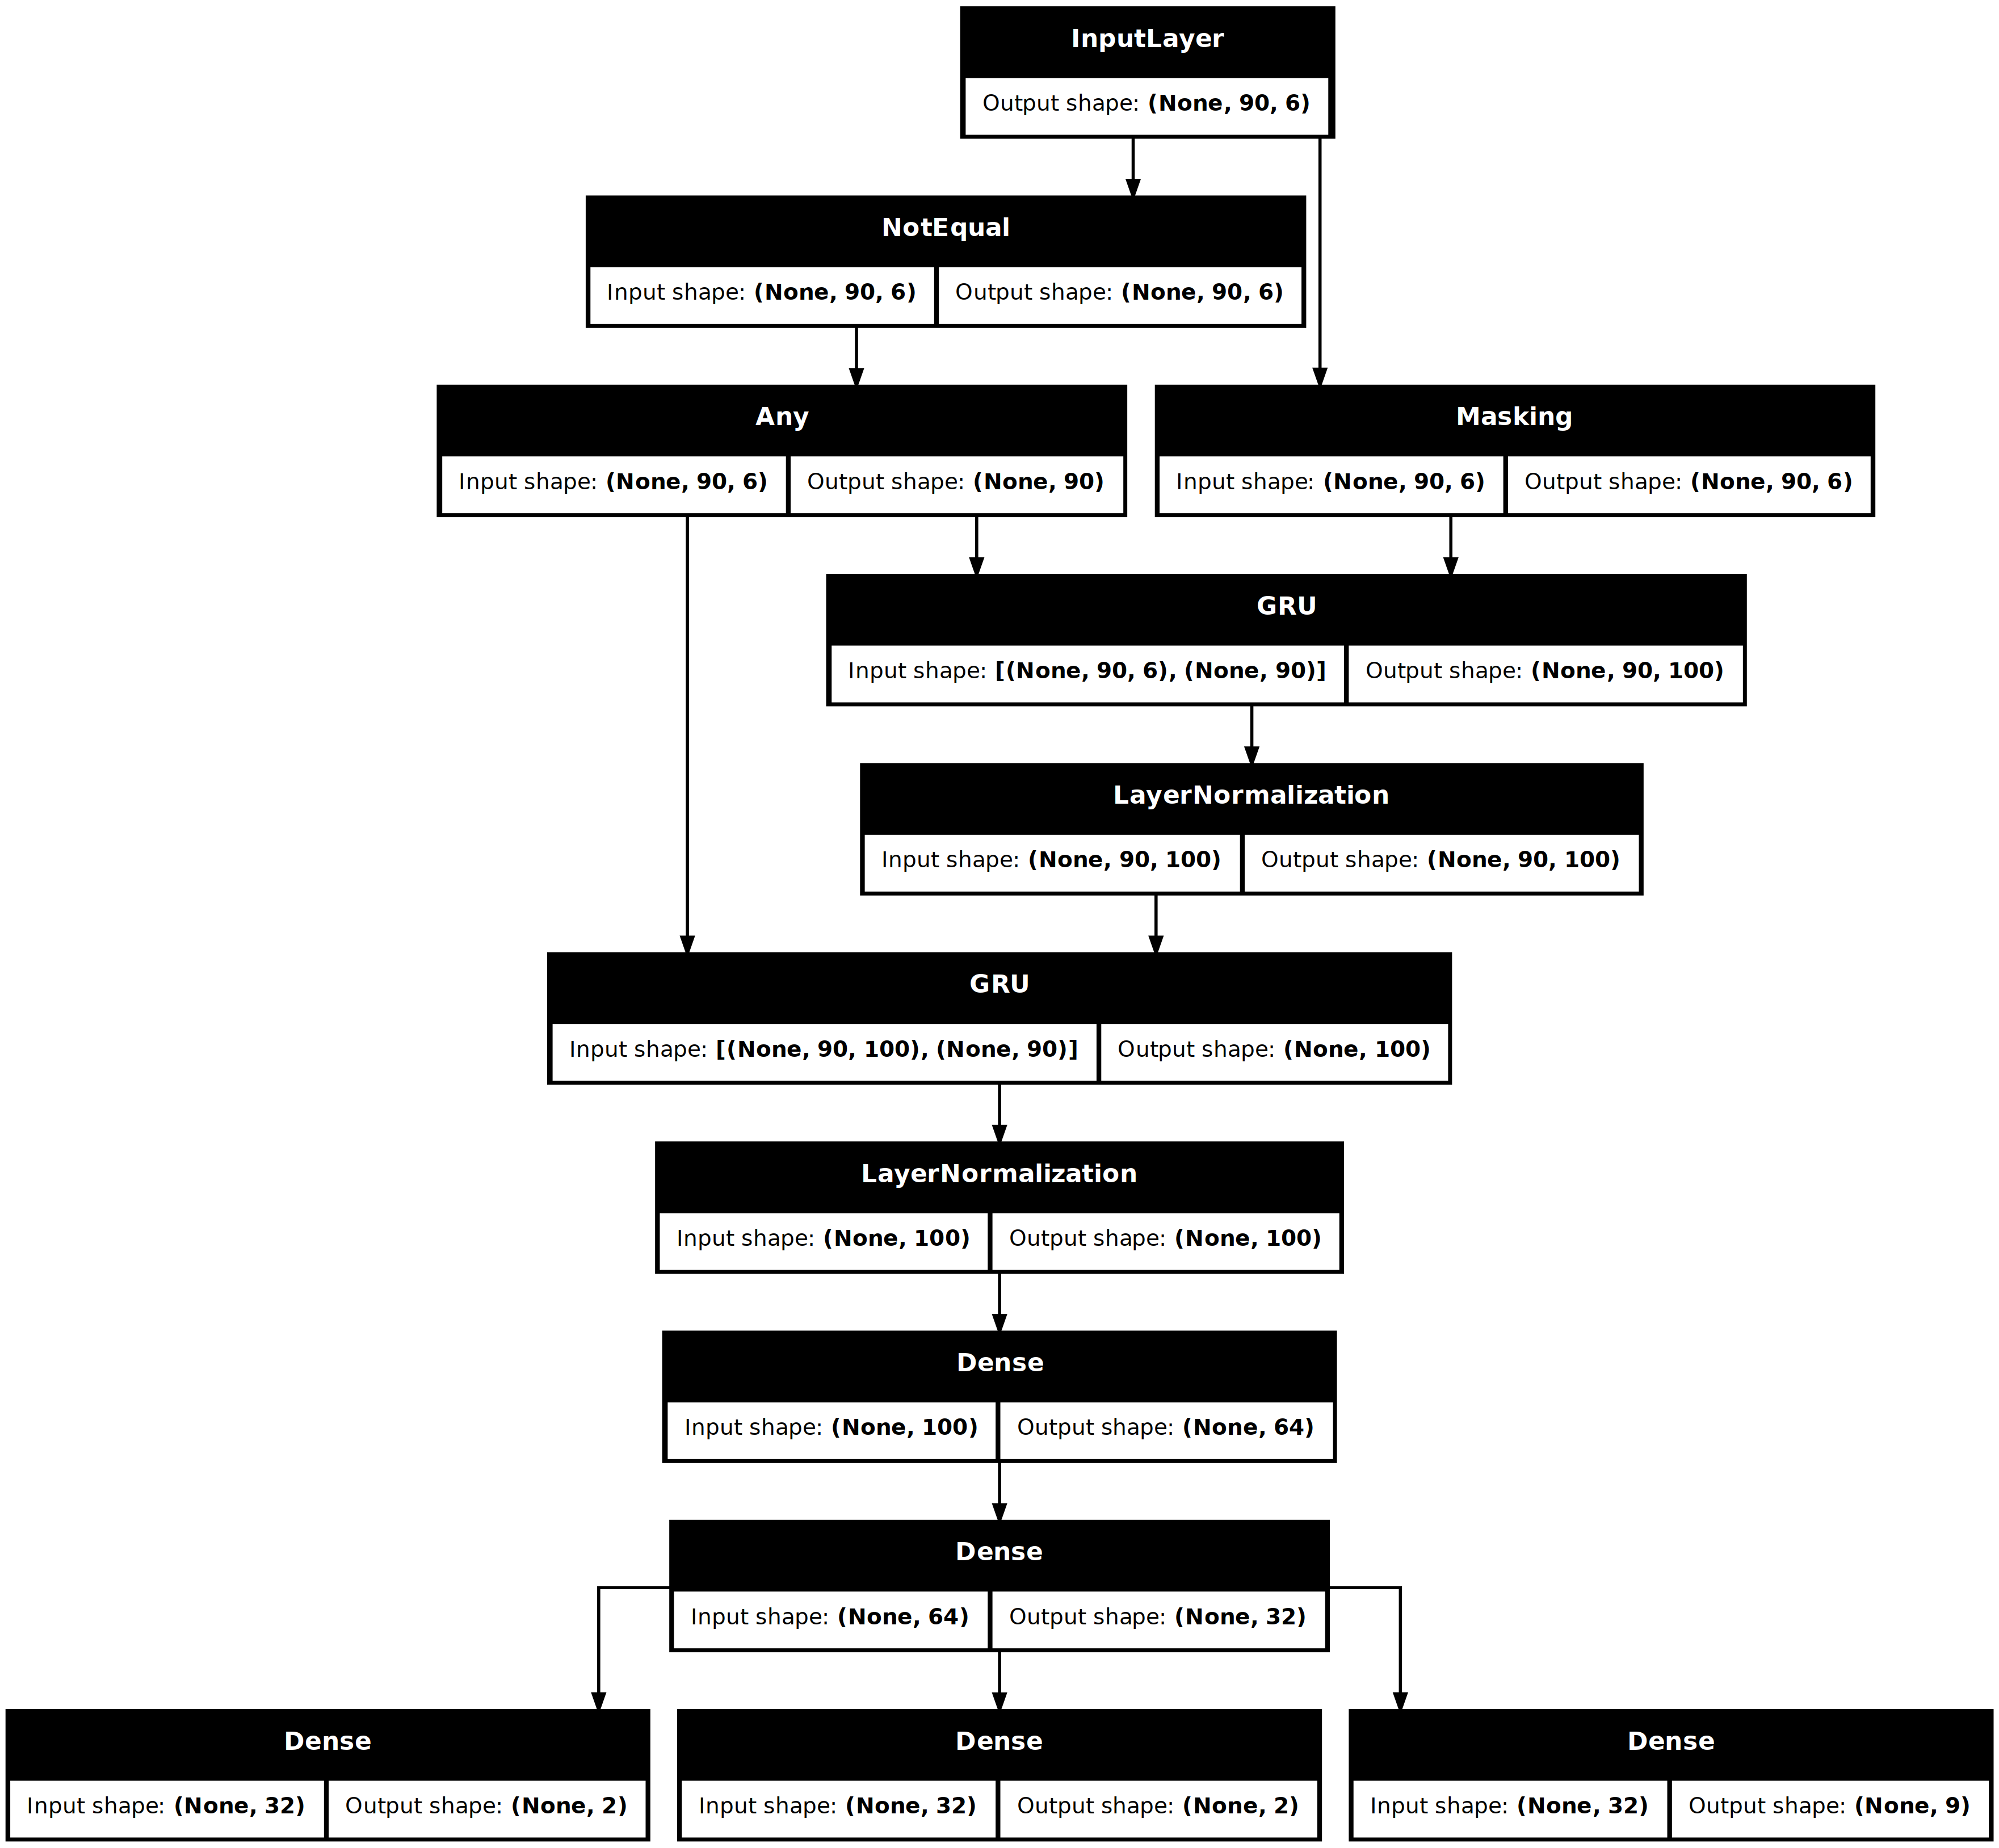

In [24]:
keras.utils.plot_model(encoder, show_shapes=True)

In [25]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon * 0.1

## decoder

In [26]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9000)           │        27,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 90, 100)        │           200 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 90, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 90, 100)        │           200 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 90, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90, 64)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 90, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 90, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,342 (614.62 KB)

 Trainable params: 157,342 (614.62 KB)

 Non-trainable params: 0 (0.00 B)

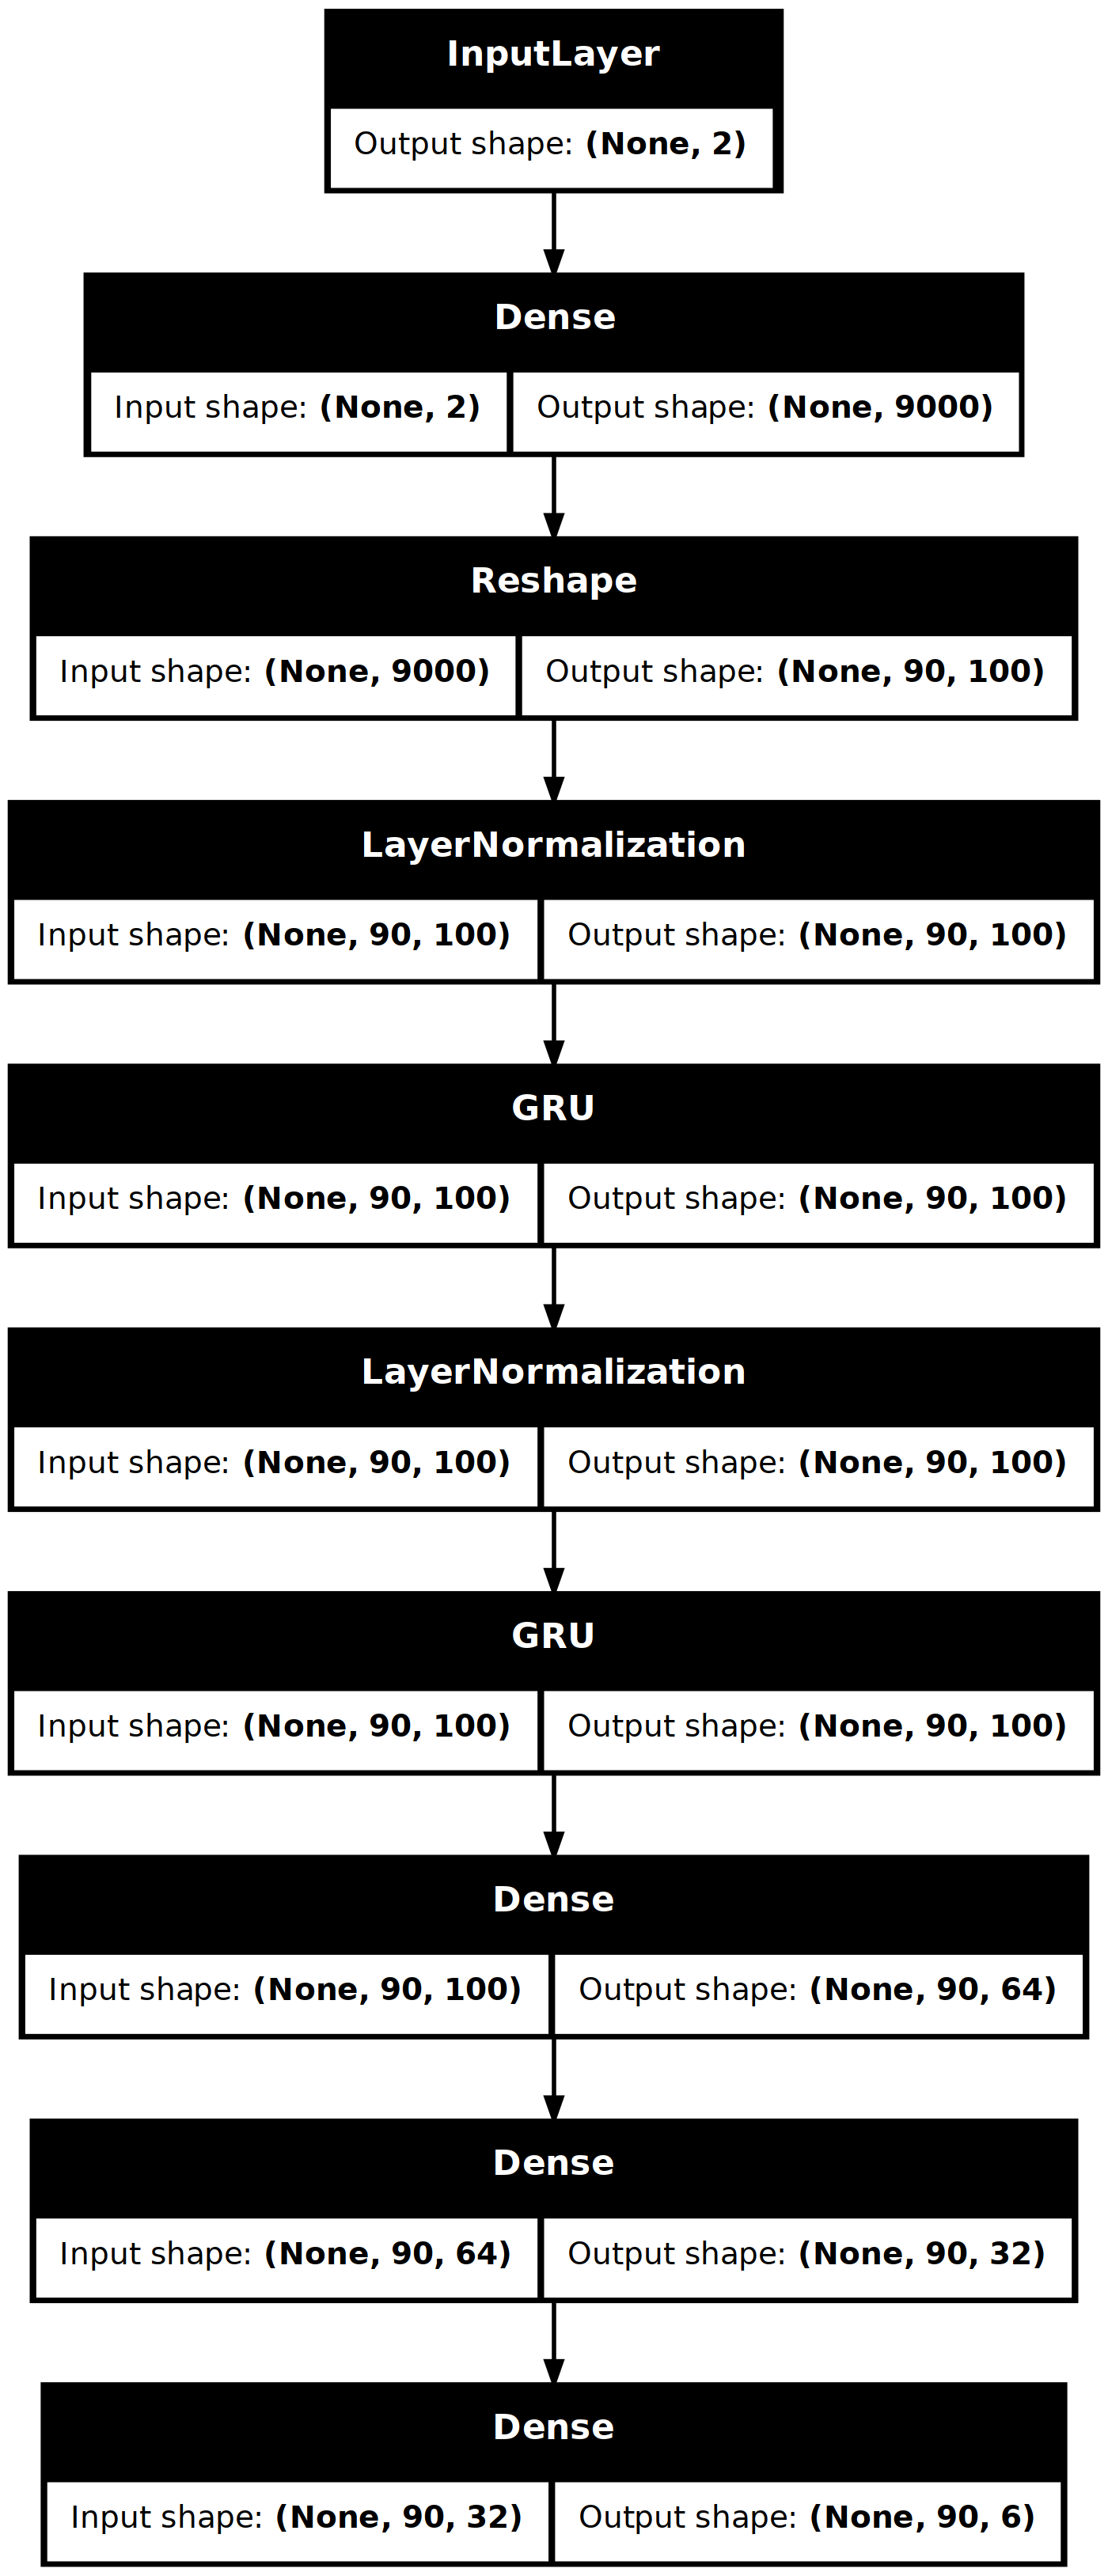

In [27]:
keras.utils.plot_model(decoder, show_shapes=True)

# try to add restriction to the variation autoencoder

In [29]:
classification_weight = 10

In [30]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.classification_tracker = keras.metrics.Mean(name="classification_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.classification_tracker
               ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, a= self.encoder(data[0][0])
            b,c,classification_probability = self.encoder(data[0][1])
            
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data[1][0], reconstruction)
                )
            )
            
            """
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data[1][0],reconstruction)
            )*reconstruction_weight
            """
            
            #reconstruction_loss = tf.losses.mean_squared_error(data[1][0],reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            classification_loss = keras.losses.categorical_crossentropy(data[1][1], classification_probability)*classification_weight
            
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss) + tf.reduce_mean(classification_loss)

            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.classification_tracker.update_state(classification_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "classification_loss": self.classification_tracker.result()
        }

In [ ]:
epochs = 5000
batch_size = 1024
vae = VAE(encoder, decoder)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_1.keras", save_best_only=True, monitor="classification_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="classification_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="classification_loss", patience=50, verbose=1, mode='min'),
]
vae.compile(
    optimizer="rmsprop",
    run_eagerly=True
)

history = vae.fit(
    [mask_data, mask_labeled_data],
    [data, labeled_label],
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    #validation_split=0.2,
    verbose=1,
)

Epoch 1/5000


2024-12-30 20:12:03.483372: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - classification_loss: 23.3369 - kl_loss: 3.2204 - reconstruction_loss: 2190.6208 - total_loss: 2217.1780 - learning_rate: 0.0010
Epoch 2/5000


/home/yltang/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - classification_loss: 20.8394 - kl_loss: 4.8653 - reconstruction_loss: 945.6485 - total_loss: 971.3526 - learning_rate: 0.0010
Epoch 3/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 348ms/step - classification_loss: 18.0302 - kl_loss: 4.8951 - reconstruction_loss: 735.3751 - total_loss: 758.3005 - learning_rate: 0.0010
Epoch 4/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - classification_loss: 15.7144 - kl_loss: 4.8329 - reconstruction_loss: 628.0128 - total_loss: 648.5600 - learning_rate: 0.0010
Epoch 5/5000


In [ ]:
(20.4264/1024)

In [ ]:
(19/1024)/np.mean(train_data)

In [ ]:
metric = "loss"
for i, b in enumerate(history.history["classification_" + metric]):
    history.history["classification_" + metric][i] = history.history["classification_" + metric][i]/max(history.history["classification_" + metric])

for i, b in enumerate(history.history["reconstruction_" + metric]):
    history.history["reconstruction_" + metric][i] = history.history["reconstruction_" + metric][i]/max(history.history["reconstruction_" + metric])

#for i, b in enumerate(history.history["kl_" + metric]):
#   history.history["kl_" + metric][i] = history.history["kl_" + metric][i]/max(history.history["kl_" + metric])

In [ ]:
metric = "loss"
plt.figure()
#plt.plot(history.history["kl_"+metric])
plt.plot(history.history["reconstruction_" + metric])
plt.plot(history.history["classification_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["reconstruct_loss","classification"], loc="best")
plt.show()
plt.close()

In [ ]:
vae.encoder.save(f"LSTM_encoder.keras")
vae.decoder.save(f"LSTM_decoder.keras")

# 加载和测试模型

In [ ]:
from keras.models import load_model
vae_decoder = load_model("/home/yltang/data/work_1/LSTM_decoder.keras")
vae_encoder = load_model("/home/yltang/data/work_1/LSTM_encoder.keras")

In [ ]:
z_mean, z_log_var, pred = vae_encoder.predict(mask_data)

In [ ]:
plt.figure(figsize=(12,10),)
#         dpi=1000)
colors = ["darkgrey", "lightgreen","aquamarine","lightblue","mediumpurple","plum","bisque","yellow","rosybrown","khaki","blue"]
colors_ = ["k",'green',"turquoise","blue","blueviolet","violet","darkorange","y","brown","darkkhaki","mediumblue"]
labels = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIs-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
markers = ["+", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "d"]
for i in range(len(colors)-2):
    plotlist = []
    for j in range(z_mean.shape[0]):
        #if np.argmax(test_label[j,0,:])==i:
        if np.argmax(unlabeled_label[j,:])==i:
            plotlist.append(j)
    mean_x = np.mean(z_mean[plotlist, 0])
    mean_y = np.mean(z_mean[plotlist, 1])
    var_x = np.var(z_mean[plotlist,0])
    var_y = np.var(z_mean[plotlist,1])
    #print(f"mean_x:{mean_x} mean_y:{mean_y}, var_x:{var_x} var_y:{var_y}")
    
    x = np.linspace(mean_x-np.abs(var_x), mean_x+np.abs(var_x))
    x_ = np.zeros(shape=x.shape) + mean_x
    y = np.linspace(mean_y-np.abs(var_y), mean_y+np.abs(var_y))
    y_ =np.zeros(shape=y.shape) + mean_y
    
    #plt.plot(x,y_, color=colors_[i], linewidth=1.2)
    #plt.plot(x_,y,color=colors_[i], linewidth=1.2)
    #plt.scatter(mean_x, mean_y,s=60, c="k",marker='o', alpha=1)
    #plt.annotate(labels[i], xy = (mean_x, mean_y), xytext = (mean_x-0.2, mean_y-0.2), color=colors[i],fontsize="large",fontproperties="Times New Roman")
    # 这里xy是需要标记的坐标，xytext是对应的标签坐标
    
    plt.scatter(
        z_mean[plotlist, 0],
        z_mean[plotlist, 1],
        c=colors[i],
        s=30,
        label=labels[i],
        marker=markers[i],
        alpha=0.6
                )

plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
    
plt.xlabel("latent_feature_1",fontsize="xx-large",labelpad=10)
plt.ylabel("latent_feature_2",fontsize="xx-large",labelpad=10)
#plt.legend(fontsize="xx-large",bbox_to_anchor=(1.3, 1),loc="upper right",
#         prop=font1,
#         borderaxespad=0.)

plt.legend(fontsize="x-large",loc="best",
#         prop=font1,
         framealpha=0.2,
         borderaxespad=0.)
'''
plt.xticks(fontsize="xx-large",fontproperties="Times New Roman")
plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")
    
plt.xlabel("latent_feature_1",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
plt.ylabel("latent_feature_2",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
#plt.legend(fontsize="xx-large",bbox_to_anchor=(1.3, 1),loc="upper right",
#         prop=font1,
#         borderaxespad=0.)

plt.legend(fontsize="x-large",loc="best",
         prop=font1,
         framealpha=0.2,
         borderaxespad=0.)
'''

#plt.savefig(f"latent_distribution.jpg",bbox_inches='tight')
plt.show()

In [ ]:
batch_size = tf.shape(z_mean)[0]
z_size = tf.shape(z_mean)[1]
epsilon  = tf.random.normal(shape=(batch_size, z_size))
#sampling_vector = z_mean + tf.exp(0.5 * z_log_var[3]) * epsilon

sampling_vector = z_mean
reconstuct  = vae_decoder(sampling_vector)

In [ ]:
markers = ["d", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "+"]
color = ['blueviolet','blue',"green",'orange','red','m']
fmt = ['dm','og','vr','^k','<y','>m']
labels = ['u','g','r','i','z','y']

In [ ]:
reconstuct.shape

In [ ]:
id_ = 0

In [ ]:
# 1. 相关模块导入
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 正常显示中文字体
#plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 3. 绘图
  # 3.1 共享X轴
figure,(ax1,ax2,ax3) = plt.subplots(1,3,
                                    figsize=(6*3,5),
                                    #dpi=1000,
                                    # 共享x轴
                                    sharey=True)
id_ = id_ + 1

# 2. 创建制图数据
ax_list = [ax1,ax2,ax3]
for i in range(3):
    mjd = np.linspace(0,89,90)
    flux_1 = data[id_,:,i]
    flux_err_1 = data[id_,:,i+3]

    flux_2 = reconstuct[id_,:,i]
    flux_err_2 = reconstuct[id_,:,i+3]
    

    flux_3 = data[id_,:,i]
    flux_err_3 = data[id_,:,i+3]
    
    flux_list = [flux_1,flux_2,flux_3]
    flux_err_list = [flux_err_1, flux_err_2,flux_err_3]
    
    for j in range(3):
        ax_list[j].errorbar(x=mjd, y=flux_list[j], yerr=flux_err_list[j],fmt=fmt[i], capsize=2,label=label[i])
        #ax_list[j].errorbar(x=mjd_1, y=flux_list[j], yerr=flux_err_list[j],color=color[i], marker=markers[i], capsize=2,label=label[i])
        #if j==0:
        #    ax_list[j].set_ylabel("Normalized Flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
        #elif j==1:
        #    ax_list[j].set_xlabel("Times",fontsize="xx-large",labelpad=30,fontproperties="Times New Roman")
        #ax_list[j].legend(fontsize="xx-large",loc="upper right",prop=font1)
        #设置坐标轴字体
        #x1_label = ax_list[j].get_xticklabels() 
        #[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
        #y1_label = ax_list[j].get_yticklabels() 
        #[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]

     
        # 2.4 坐标轴刻度字体颜色设置
        ax_list[j].tick_params(axis='y',
                     labelsize=20, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
        ax_list[j].tick_params(axis='x',
                     labelsize=20, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
        ax_list[i].legend(fontsize="x-large",
                      #bbox_to_anchor=(0,0.34,1.028, 1),
                      loc="upper right",
                      framealpha=0.2,
                      #prop=font1
                     )

# 调整子图形之间的纵向距离
figure.subplots_adjust(wspace=0.05) 

#plt.savefig("reconstruction_1.jpg",bbox_inches='tight')

plt.show()

In [ ]:
guess=[]

for i in range (len(data)):
    guess.append(np.argmax(pred[i,:]))

In [ ]:
ture=[]

for i in range (len(data)):
    ture.append(np.argmax(label[i,:]))

In [ ]:
guess[:20],ture[:20]

In [ ]:
max(pred[0,:])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

confusion = confusion_matrix(ture,guess,normalize='true')

In [ ]:
import matplotlib

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.047)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labelsize=12,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_ylabel('True Label',fontsize="xx-large",labelpad=20,fontproperties="Times New Roman")
    ax.set_xlabel('Predicted Label',fontsize="xx-large",labelpad=30,fontproperties="Times New Roman",loc="center")
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), fontsize=12,**kw)
            texts.append(text)

    return texts

In [ ]:
fig, ax = plt.subplots(figsize=(10,10),)
#                      dpi=1000)
im, cbar = heatmap(data=confusion, row_labels = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIs-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
                      ,col_labels=[
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIs-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE'], ax=ax,
                   cmap="Blues")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
#plt.savefig(f"Confusion_matrix_{number}.jpg",bbox_inches='tight')
plt.show()

In [ ]:
cm = confusion_matrix(ture,guess)

In [ ]:
cm.shape

In [ ]:
help(ax.bar)

In [ ]:
#precision recall
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

fig, ax = plt.subplots(figsize=(10,5),
                       dpi=1000
                      )
labels = ture
x = np.arange(9)  # the label locations
width = 0.4  # the width of the bars
rects1 = ax.bar((x- width/2), precision, width, label='Precision')
rects2 = ax.bar((x+ width/2), recall, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores',fontsize="xx-large",labelpad=20,fontproperties="Times New Roman")
#ax.set_title('Precision/Recall per class')
ax.set_xticks(x)
ax.set_xticklabels([
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
ax.tick_params(axis='y',
                         labelsize=15,# y轴字体大小设置
                         pad=10,
                         #color='r',    # y轴标签颜色设置  
                         #labelcolor='b', # y轴字体颜色设置
                         direction='in' # y轴标签方向设置
                          ) 
ax.tick_params(axis='x',
                         labelsize=15, # y轴字体大小设置
                         pad=10,
                         #color='r',    # y轴标签颜色设置  
                         #labelcolor='b', # y轴字体颜色设置
                         direction='in' # y轴标签方向设置
                          ) 

plt.legend(fontsize="xx-large",
           #bbox_to_anchor=(0,0.3,1, 1),
           loc="upper right",
           framealpha=0.2,
           prop=font1,
           #borderaxespad=0.
          )
#这里注意需要改一下参数
plt.savefig(f'PvsR_barplot_{number}.png')

In [ ]:
precision

In [ ]:
recall

In [ ]:
macro_P = np.mean(precision)
macro_R = np.mean(recall)
macro_F1 = (2*macro_P*macro_R)/(macro_P+macro_R)

print(macro_P, macro_R, macro_F1)

In [ ]:
def sort_probability_index(pred, label):
    probability_list = []
    for sample in range(len(pred)):
        probability_list.append(pred[sample][label])
    sorted_probability_index = sorted(range(len(probability_list)), key=lambda k:probability_list[k])
    return sorted_probability_index

In [ ]:
from tqdm import tqdm
precision_list = []
recall_list = []
fpr_list = []
ture_array = np.array(ture)
pred_array = np.zeros(shape=(len(pred),))

In [ ]:
ture[:10], ture_array[:10]

In [ ]:
print(pred[0])
print(pred_array[:10])

In [ ]:
for labels in range(9):
    print(f"class {labels}")
    x_step = 1/ len(ture)
    recall_ = []
    fpr_ = []
    ture_ = []
    sorted_probability_index = sort_probability_index(pred=pred, label=labels)
    ture_array_ = ture_array.copy()
    pred_array_ = pred_array.copy()
    ture_array_ = ture_array_[sorted_probability_index]
    pred_array_ = pred_array_[sorted_probability_index]

    for sample in range(len(ture)):
        if ture_array_[sample] == labels:
            ture_.append(0)
        else:
            ture_.append(1)


    with tqdm(total=len(pred)*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar: 
        for i in range(len(pred)):
            guess_ = pred_array_.copy()
            guess_[i:] = 1
            
            cm = confusion_matrix(ture_,guess_)
            #print(cm)
            recall = cm.diagonal()[0]/np.sum(cm,axis=1)[0]
            FPR = (np.sum(cm,axis=0)[0]-cm.diagonal()[0])/np.sum(cm,axis=1)[1]
            #print(f"precision: {precision}, recall: {recall}, FPR: {FPR}")
            recall_.append(recall)
            fpr_.append(FPR)                
            pbar.update(10)
            
    recall_list.append(recall_)
    fpr_list.append(fpr_)

In [ ]:
len(recall_list)

In [ ]:
ROC_params = dict()
ROC_params[f'recall_list'] = recall_list
ROC_params[f'fpr_list'] = fpr_list
    

import json
ROC_params_json = json.dumps(ROC_params,sort_keys=False, indent=4, separators=(',', ': '))
print(type(ROC_params_json))
f = open(f'ROC_params_{number}.json', 'w')
f.write(ROC_params_json)
f.close()

In [ ]:
# JSON到字典转化
import json
ROC_params = open(f'ROC_params_{number}.json', 'r')
ROC_info = json.load(ROC_params)

In [ ]:
fpr_list = ROC_info["fpr_list"]
recall_list = ROC_info["recall_list"]

In [ ]:
type(fpr_list), type(recall_list)

In [ ]:
AUC_list = []
for i in range(9):
    recall_list_plus = recall_list[i] + [1.0]
    del recall_list_plus[0]
    recall_step = np.array(recall_list_plus) - np.array(recall_list[i])
    AUC = 0
    for j, step in enumerate(recall_step):
        AUC = AUC + step * fpr_list[i][j]
    
    AUC_list.append(AUC)

In [ ]:
colors = ["darkgrey", "lightgreen","aquamarine","lightblue","mediumpurple","plum","bisque","yellow","rosybrown","khaki","blue"]

In [ ]:
label = [
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE']
plt.figure(figsize=(12,10),
           dpi=1000)
for i in range(9):
    x = recall_list[i]
    y = fpr_list[i]
    plt.plot(x,y, label=f"{label[i]} AUC: {AUC_list[i]:.2f}",color=colors[i],lw=2.0, alpha=1.0)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    #plt.plot(x,x)

    plt.ylabel("True Positive Rate",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman") 
    plt.xlabel("False Positive Rate",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.legend(fontsize="xx-large",loc="lower right",prop=font1)
    plt.xticks(fontsize="xx-large",fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")

plt.savefig(f"ROC_curve_{number}.jpg",bbox_inches='tight')
plt.show()